## Code to Chapter 2 of LangChain for Life Science and Healthcare book, by Dr. Ivan Reznikov

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1WJ4w_kHqHkkxFK9axnLdgXJKSKkS8viw?usp=sharing)


## Healthcare Clinical Assistant - Advanced Medical Coding & Analysis

This notebook demonstrates the implementation of an AI-powered healthcare clinical assistant that leverages multiple language models and Google Cloud Healthcare APIs to assist with medical coding, diagnosis suggestions, and patient data analysis.

## Table of Contents
1. [Environment Setup](#environment-setup)
2. [Medical Coding Overview](#medical-coding-overview)
3. [Local Medical Models](#local-medical-models)
4. [Google Cloud Healthcare API Integration](#google-cloud-healthcare-api-integration)
5. [ReAct Agent Implementation](#react-agent-implementation)
6. [SQL Database Integration](#sql-database-integration)
7. [Speech-to-Text Processing](#speech-to-text-processing)
8. [Medical Text Correction](#medical-text-correction)
9. [Text Summarization](#text-summarization)
10. [Report Generation System](#report-generation-system)
11. [Multi-Agent Architecture](#multi-agent-architecture)
12. [Research and Brainstorming Tools](#research-and-brainstorming-tools)


## Environment Setup

### Package Installation

In [ ]:
!pip install -q pyarrow==15.0.2
!pip install -q langchain langchain_openai langchain_community langchain_huggingface langchain_anthropic langgraph openai langchain-google-vertexai
!pip install -q redlines markdown transformers accelerate bitsandbytes pydub markdown_pdf google-cloud-aiplatform
!pip install -q optimum auto-gptq arxiv xmltodict semanticscholar

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-google-vertexai 2.0.27 requires pyarrow<20.0.0,>=19.0.1, but you have pyarrow 15.0.2 which is incompatible.


- **LangChain ecosystem**: Agent orchestration and tool integration
- **Google Cloud AI**: Vertex AI and Healthcare API access
- **Medical AI models**: Specialized healthcare language models
- **Data processing**: Audio, PDF, and structured data handling

In [ ]:
!pip freeze | grep "langc\|openai\|googl\|transf\|numpy"

google==2.0.3
google-ai-generativelanguage==0.6.15
google-api-core==2.25.1
google-api-python-client==2.176.0
google-auth==2.38.0
google-auth-httplib2==0.2.0
google-auth-oauthlib==1.2.2
google-cloud-aiplatform==1.104.0
google-cloud-bigquery==3.35.0
google-cloud-bigquery-connection==1.18.3
google-cloud-bigquery-storage==2.32.0
google-cloud-core==2.4.3
google-cloud-dataproc==5.21.0
google-cloud-datastore==2.21.0
google-cloud-firestore==2.21.0
google-cloud-functions==1.20.4
google-cloud-iam==2.19.1
google-cloud-language==2.17.2
google-cloud-resource-manager==1.14.2
google-cloud-spanner==3.55.0
google-cloud-storage==2.19.0
google-cloud-translate==3.21.1
google-colab @ file:///colabtools/dist/google_colab-1.0.0.tar.gz
google-crc32c==1.7.1
google-genai==1.26.0
google-generativeai==0.8.5
google-pasta==0.2.0
google-resumable-media==2.7.2
googleapis-common-protos==1.70.0
googledrivedownloader==1.1.0
grpc-google-iam-v1==0.14.2
hf_transfer==0.1.9
jupyter_kernel_gateway @ git+https://github.com/goo

In [ ]:
from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get("LC4LS_OPENAI_API_KEY")
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
os.environ["ANTHROPIC_API_KEY"] = userdata.get("ANTHROPIC_API_KEY")
os.environ["SCOPUS_API_KEY"] = userdata.get("SCOPUS_API_KEY")
os.environ["LC4LS_GCLOUD_PROJECT_ID"] = userdata.get("LC4LS_GCLOUD_PROJECT_ID")

os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = userdata.get("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "lc4ls_ch9"

os.environ["OPENAI_API_KEY"] = userdata.get("LC4LS_OPENAI_API_KEY")

**Security Note**: API keys are securely stored using Google Colab's userdata feature, ensuring credentials aren't exposed in the notebook.

### Data Preparation

In [ ]:
!mkdir results
!mkdir data
!mkdir data/audio
!mkdir data/transcripts

mkdir: cannot create directory ‘results’: File exists
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/audio’: File exists
mkdir: cannot create directory ‘data/transcripts’: File exists


In [ ]:
!wget --no-check-certificate 'https://github.com/IvanReznikov/LangChain4LifeScience/raw/refs/heads/main/data/datasets/ch10_doctors_notes.mp3' -O data/audio/doctors_notes_001.mp3
!wget --no-check-certificate 'https://github.com/IvanReznikov/LangChain4LifeScience/raw/refs/heads/main/data/datasets/ch10_kidney_scenario.json' -O data/kidney_scenario.json
!wget --no-check-certificate 'https://github.com/IvanReznikov/LangChain4LifeScience/raw/refs/heads/main/data/datasets/ch10_doctors_visit_template.md' -O data/doctors_visit_template.md
!wget --no-check-certificate 'https://github.com/IvanReznikov/LangChain4LifeScience/raw/refs/heads/main/data/datasets/ch10_doctors_visit_schema.json' -O data/doctors_visit_schema.json
!wget --no-check-certificate 'https://github.com/IvanReznikov/LangChain4LifeScience/raw/refs/heads/main/data/datasets/ch10_doctors_visit_examples.json' -O data/doctors_visit_examples.json
!wget --no-check-certificate 'https://github.com/IvanReznikov/LangChain4LifeScience/raw/refs/heads/main/data/datasets/ch10_patients_synthetic_data.csv' -O data/patients_synthetic_data.csv
!wget --no-check-certificate 'https://github.com/IvanReznikov/LangChain4LifeScience/raw/refs/heads/main/data/datasets/ch10_patients_visits_data.csv' -O data/patients_visits_data.csv
!wget --no-check-certificate 'https://github.com/IvanReznikov/LangChain4LifeScience/raw/refs/heads/main/data/datasets/ch10_doctors_notes_transcript_001.txt' -O data/transcripts/doctors_notes_transcript_001.txt
!wget --no-check-certificate 'https://github.com/IvanReznikov/LangChain4LifeScience/raw/refs/heads/main/data/datasets/ch10_doctors_notes_original.txt' -O data/doctors_notes_original.txt

--2025-07-24 13:47:02--  https://github.com/IvanReznikov/LangChain4LifeScience/raw/refs/heads/main/data/datasets/ch10_doctors_notes.mp3
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IvanReznikov/LangChain4LifeSciencesHealthcare/raw/refs/heads/main/data/datasets/ch10_doctors_notes.mp3 [following]
--2025-07-24 13:47:02--  https://github.com/IvanReznikov/LangChain4LifeSciencesHealthcare/raw/refs/heads/main/data/datasets/ch10_doctors_notes.mp3
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IvanReznikov/LangChain4LifeSciencesHealthcare/refs/heads/main/data/datasets/ch10_doctors_notes.mp3 [following]
--2025-07-24 13:47:02--  https://raw.githubusercontent.com/IvanReznikov/LangChain4LifeSciencesHealthcare/refs/heads/main/data/datasets/ch10

**Data Asset**: Sample doctor's audio notes that can be processed for transcription and medical entity extraction.

In [ ]:
from markdown_pdf import MarkdownPdf, Section
import json


def save_json(filename, data):
    with open(filename, "w") as f:
        json.dump(data, f)


def load_json(filename):
    with open(f"data/{filename}.json", "r") as json_file:
        return json.load(json_file)


def load_markdown(filename):
    with open(filename, "r") as template_file:
        return template_file.read()


def save_markdown(filename, data):
    with open(filename, "w") as output_file:
        output_file.write(data)

## Overview

Medical coding errors are common and can lead to denied claims, delayed payments, and even patient safety issues. Gen AI can help address these issues by suggesting accurate medical codes, automating tasks, and improving standardization. With a human-in-the-loop approach, this can lead to faster claims processing, better reimbursement, and reduced coder burnout.

Google's large language models (LLMs) have the potential to significantly automate the medical coding process, improving both efficiency and accuracy. By first preprocessing medical records using Healthcare APIs to identify and extract relevant terms, patterns, and relationships, we can then leverage LLMs to suggest appropriate codes for diagnoses and procedures based on physician notes and reports. This will not only save coders time and effort but also reduce errors and inconsistencies, leading to improved reimbursement rates and better financial management for healthcare providers.

**It is always recommended to have a human-in-the-loop when dealing with medical applications. This Colab is meant to accelerate the medical coding processing and not to fully replace a human coder.**

### Intro to Medical Codes

Medical coding is the transformation of healthcare diagnoses, procedures, medical services, and equipment into standardized alphanumeric codes. These codes represent specific clinical information in a standardized format, facilitating communication between healthcare providers, payers, and researchers. Medical codes provide data points about diagnoses, procedures, and resource utilization.

<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/fqNBNE_YSro?si=JKaKOWfzdxeFFADe" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

*   **ICD-10 Codes**: International Classification of Diseases, 10th Revision. These are Diagnosis Codes for Conditions Such as Diabetes or Pneumonia.  They Are Also the Codes for Symptoms Such as Headache or Chest Pain.

*   **CPT Codes**:  Current Procedural Terminology. These are Procedures Codes that Describe What is Done by the Healthcare Provider, Hospital, etc., such as MRI, Gall Bladder Surgery or Complete Blood Count Lab Test.  CPT Codes are Also Used for Doctor's Office Visits... These CPT Codes are Referred to as E/M Codes for Evaluation and Management Codes.

*   **DRG Codes**: Diagnosis Related Groups. DRG Codes are Used for Inpatient Medical Services.  A Hospitalized Patient May Have Multiple ICD-10 Diagnosis Codes and Multiple CPT Codes and these will be 'Rolled Into' One DRG Diagnosis Related Group for that Hospital Stay.

*   **HCPCS Codes**: Healthcare Common Procedure Coding System. HCPCS Codes are Also Procedures Codes, but They Are for Procedures that Are Not a Part of the CPT Coding System.  Many Special Medications that are Administered in the Hospital are Coded with a HCPCS Code Because a CPT Code for Them Does Not Exist.

## Local Medical Models

### Model Configuration Options

In [ ]:
from pydantic import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool

In [ ]:
import transformers
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

❗IMPORTANT:

<font color='red'>if you get an error don't panic - simply restart the notebook and run all cells. This issue is well known for google colab❗

Just click on Runtime -> Restart session and run all
</font>

In [ ]:
# Configuration flags for different model modes
LOCAL_LLM_MODE = False  # Enable local model processing
MEDALPACA_MODE = False  # Use MedAlpaca 7B model
MEDALLAMA_MODE = False  # Use Medical Llama 3 model
HIGH_RAM_MODE = False  # Enable high-memory models

**Resource Management**: These flags allow selective model loading based on available computational resources.

In [ ]:
# Doctors' observations
doctors_notes_raw_input = """
    Patient is John Baker. The patient's reason for the visit was due to cough and high temperature,
    which should be noted as fever and cough. Physical examination reveals no significant abnormalities
    in vital signs, with a blood pressure reading of 120/80 mmHg and a heart rate of 72 bpm. No visible
    edema or significant weight changes noted; the patient weighs 160 lbs and has a height of 5'10".
    The patient is in good health and prescribed antibiotics with instructions to take one tablet every
    8 hours with food. Additionally, the patient's next appointment is scheduled for a follow-up in 2 weeks
"""

### MedAlpaca Implementation

**Model Characteristics**:
- **MedAlpaca**: 7B parameter model fine-tuned on medical data
- **Quantization**: Uses 4-bit quantization for memory efficiency
- **Temperature**: Low temperature (0.001) for consistent medical advice

In [ ]:
if LOCAL_LLM_MODE and MEDALPACA_MODE:
    model = AutoModelForCausalLM.from_pretrained(
        "PrunaAI/medalpaca-medalpaca-7b-bnb-4bit-smashed",
        trust_remote_code=True,
        device_map="auto",
    )
    tokenizer = AutoTokenizer.from_pretrained("medalpaca/medalpaca-7b")


@tool
def call_medalpaca(text):
    """
    Medical model medalpaca. Answers questions regarding possible illnesses and treatment based on doctors notes
    """
    prompt = f"You are a professional doctor.\n\nContext: Doctors notes: {text}.\n\nQuestion: List all potential illnesses and treatment\n\nAnswer: Possible illnesses and treatment: "
    input_ids = tokenizer(prompt, return_tensors="pt").to(model.device)["input_ids"]

    outputs = model.generate(
        input_ids,
        max_new_tokens=256,
        do_sample=True,
        temperature=0.001,
        top_k=5,
        top_p=0.95,
    )
    answer = tokenizer.decode(outputs[0])

    return answer

In [ ]:
if LOCAL_LLM_MODE and MEDALPACA_MODE:
    response = call_medalpaca(doctors_notes_raw_input)
    print(response)

### Medical Llama Implementation

**Advanced Features**:
- **Chat Template**: Structured conversation format for medical consultation
- **JSL MedLlama**: John Snow Labs' specialized medical model
- **Pipeline Integration**: Streamlined inference process


In [ ]:
if LOCAL_LLM_MODE and MEDALLAMA_MODE:
    model = "johnsnowlabs/JSL-MedLlama-3-8B-v17-8bits"
    tokenizer = AutoTokenizer.from_pretrained(model)
    js_pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        torch_dtype=torch.float16,
        device_map="auto",
    )


@tool
def call_medllama(text):
    """
    Medical model medllama. Answers questions regarding possible illnesses and treatment based on doctors notes
    """
    messages = [
        {
            "role": "system",
            "content": """
          You are a professional doctor.
          You are given doctors notes.
          Suggest possible illnesses and treatment.""",
        },
        {"role": "user", "content": text},
    ]
    prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    pipe = js_pipeline(
        prompt,
        max_new_tokens=256,
        do_sample=True,
        temperature=0.001,
        top_k=5,
        top_p=0.95,
    )
    return pipe[0]["generated_text"]

In [ ]:
if LOCAL_LLM_MODE and MEDALLAMA_MODE:
    response = call_medllama(doctors_notes_raw_input)
    print(response)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# https://huggingface.co/internistai/base-7b-v0.2

device = "cuda"
if LOCAL_LLM_MODE and HIGH_RAM_MODE:
    model = AutoModelForCausalLM.from_pretrained("internistai/base-7b-v0.2")
    tokenizer = AutoTokenizer.from_pretrained("internistai/base-7b-v0.2")


if LOCAL_LLM_MODE and HIGH_RAM_MODE:

    @tool
    def call_internistai(text):
        """
        Medical model internistai. Answers questions regarding possible illnesses and treatment based on doctors notes
        """
        messages = [
            {
                "role": "system",
                "content": """
            You are a professional doctor.
            You are given doctors notes.
            Suggest possible illnesses and treatment.""",
            },
            {"role": "user", "content": text},
        ]

        encodeds = tokenizer.apply_chat_template(
            messages, add_generation_prompt=True, return_tensors="pt"
        )

        model_inputs = encodeds.to(device)
        model.to(device)

        generated_ids = model.generate(
            model_inputs,
            max_new_tokens=256,
            do_sample=True,
            temperature=0.001,
            top_k=5,
            top_p=0.95,
        )
        decoded = tokenizer.batch_decode(generated_ids)
        return decoded[0]

In [ ]:
if LOCAL_LLM_MODE and HIGH_RAM_MODE:
    response = call_internistai(doctors_notes_raw_input)
    print(response)

## Google Cloud Healthcare API Integration

### Project Configuration

In [ ]:
GOOGLE_VERTEX_AI_MODE = True

In [ ]:
PROJECT_ID = os.environ["LC4LS_GCLOUD_PROJECT_ID"]
LOCATION = "us-central1"

**Cloud Setup**: Google Cloud project configured for Healthcare API access in US Central region.

### API Enablement

**Services Enabled**:
- **AI Platform**: Vertex AI model access
- **Healthcare API**: Medical entity extraction and analysis

In [ ]:
if GOOGLE_VERTEX_AI_MODE:
    !gcloud services enable aiplatform.googleapis.com healthcare.googleapis.com --project $PROJECT_ID

ERROR: (gcloud.services.enable) You do not currently have an active account selected.
Please run:

  $ gcloud auth login

to obtain new credentials.

If you have already logged in with a different account, run:

  $ gcloud config set account ACCOUNT

to select an already authenticated account to use.


In [ ]:
if GOOGLE_VERTEX_AI_MODE:
    !gcloud config set healthcare/location $LOCATION

Updated property [healthcare/location].


In [ ]:
import sys
import requests
import vertexai
import google.auth
import google.auth.transport.requests
from langchain.agents import AgentType, create_react_agent
from langchain.tools import StructuredTool
from langchain_google_vertexai import VertexAI, ChatVertexAI

if GOOGLE_VERTEX_AI_MODE:
    # Additional authentication is required for Google Colab
    if "google.colab" in sys.modules:
        from google.colab import auth

        # Authenticate user to Google Cloud
        auth.authenticate_user()

    # Initialize Vertex AI
    vertexai.init(project=PROJECT_ID, location=LOCATION)

In [ ]:
# get access token
if GOOGLE_VERTEX_AI_MODE:
    creds, project = google.auth.default()
    auth_req = google.auth.transport.requests.Request()
    creds.refresh(auth_req)
    creds.token

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [ ]:
# you may need to run to login

#!gcloud auth login #--no-browser

### Medical Entity Extraction

#### Category Determination Function

**Entity Categories**: Comprehensive medical terminology classification system covering:
- **Anatomical**: Body structures and functions
- **Measurements**: Vital signs and lab values
- **Medications**: Dosage, frequency, and administration details
- **Procedures**: Medical interventions and their results
- **Problems**: Diagnoses and medical conditions

In [ ]:
from typing import List
from langchain_core.prompts import PromptTemplate
from langchain.agents import AgentExecutor
from langchain_core.output_parsers import StrOutputParser
from langchain.callbacks.tracers import ConsoleCallbackHandler
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter


def determine_categories(text):
    llm = VertexAI(model_name="gemini-1.5-pro", max_output_tokens=8042, temperature=0)
    term_list = [
        "ANATOMICAL_STRUCTURE",
        "BODY_FUNCTION",
        "BF_RESULT",
        "BODY_MEASUREMENT",
        "BM_RESULT",
        "BM_UNIT",
        "BM_VALUE",
        "LABORATORY_DATA",
        "LAB_RESULT",
        "LAB_VALUE",
        "LAB_UNIT",
        "MEDICAL_DEVICE",
        "MEDICINE",
        "MED_DOSE",
        "MED_DURATION",
        "MED_FORM",
        "MED_FREQUENCY",
        "MED_ROUTE",
        "MED_STATUS",
        "MED_STRENGTH",
        "MED_UNIT",
        "MED_TOTALDOSE",
        "PROBLEM",
        "PROCEDURE",
        "PROCEDURE_RESULT",
        "PROC_METHOD",
        "SEVERITY",
        "SUBSTANCE_ABUSE",
    ]

    prompt = PromptTemplate.from_template(
        """Given the following user question select possible categories that might apply:

    ANATOMICAL_STRUCTURE	A complex part of the human body, such as cells, organs, and systems.
    BODY_FUNCTION	A function carried out by the human body.
    BF_RESULT	The result of a body function.
    BODY_MEASUREMENT	A normal measurement of the human body, such as vital signs, obtained without any complex tests or procedures using basic instruments, such as a thermometer or a stethoscope.
    BM_RESULT	The result of a body measurement.
    BM_UNIT	The unit for a body measurement.
    BM_VALUE	The value of a body measurement.
    LABORATORY_DATA	The results of testing a bodily sample.
    LAB_RESULT	A qualitative description of laboratory data, such as "increased", "decreased", "positive", or "negative".
    LAB_VALUE	The value of an instance of the laboratory data.
    LAB_UNIT	The unit of measurement for the laboratory value.
    MEDICAL_DEVICE	A physical or virtual instrument.
    MEDICINE	A drug or other preparation for the treatment or prevention of a disease.
    MED_DOSE	A dose of a medication.
    MED_DURATION	The period of administration of a medication.
    MED_FORM	The physical characteristics of a specific medication.
    MED_FREQUENCY	The frequency at which a medication is taken.
    MED_ROUTE	A location in the body where a medication is administered.
    MED_STATUS	The status of an existing medication, such as "continue", "start", "restart", "stop", "switch", "increase", and "decrease".
    MED_STRENGTH	The amount of active ingredient in a dose of a medication.
    MED_UNIT	The unit of measurement for the active ingredient in a medication.
    MED_TOTALDOSE	The quantity of medication to take at one time.
    PROBLEM	A medical condition, including findings and diseases.
    PROCEDURE	A diagnostic or treatment procedure.
    PROCEDURE_RESULT	The results of a procedure.
    PROC_METHOD	The method used to conduct a procedure.
    SEVERITY	The severity of the medical condition.
    SUBSTANCE_ABUSE	A description of abuse of a psychoactive substance.

    Question: {question}
    Terms:

    Example: Question: "50 mg of aspirin twice a day"
    Terms: MEDICINE, MED_DOSE

    Only return mdeical terms!
    """
    )

    chain = prompt | llm | StrOutputParser()
    response = chain.invoke({"question": text})
    return [x for x in term_list if x in response]


def healthcare_nl(text: str) -> str:
    """Sends a REST request to the Healthcare Natural Language API"""
    # Set the API endpoint
    url = f"https://healthcare.googleapis.com/v1/projects/{PROJECT_ID}/locations/{LOCATION}/services/nlp:analyzeEntities"

    # Set the request headers
    headers = {
        "Authorization": f"Bearer {creds.token}",
        "X-Goog-User-Project": PROJECT_ID,
        "Content-Type": "application/json",
        "Accept": "application/json",
    }

    # Set the request data
    data = {"documentContent": text, "licensedVocabularies": ["SNOMEDCT_US", "ICD10CM"]}

    # Make the API request
    response = requests.post(url, headers=headers, data=json.dumps(data))

    return response.json()

#### Healthcare Natural Language API Tool

**Functionality**:
- **Entity Extraction**: Identifies medical terms using Google Healthcare NLP
- **Category Filtering**: Focuses on relevant medical entity types
- **Deduplication**: Removes duplicate terms for clean output

In [ ]:
@tool
def list_of_medical_terms(text: str) -> list[str]:
    """Retrieves medical terms for diagnosis, procedures, medicines, and lab data"""
    # Extract the entities from the response
    response_json = healthcare_nl(text)
    type_categories = determine_categories(text)

    print("response_json:", response_json)
    print("type_categories:", type_categories)

    try:
        medical_terms = list(
            {
                entity["text"]["content"]
                for entity in response_json["entityMentions"]
                if entity["type"] in type_categories
            }
        )
    except:
        medical_terms = type_categories

    print("medical_terms:", medical_terms)

    # Remove duplicates
    return medical_terms


@tool
def dummy_medical_llm(text: str = "", terms: list[str] = []) -> str:
    """
    Medical Doctor.
    Always call when any medical advice is required!
    Pass the doctors notes and lab results as text parameter
    Pass extracted medical terms as terms parameter
    """
    llm = VertexAI(model_name="gemini-1.5-pro", max_output_tokens=8042, temperature=0)

    prompt_template = """
    You are a professional doctor.
    The information provided is all you have.
    You must make a preliminary conclusion based on data given.

    Doctors notes: {text}
    Focus terms: {terms}

    """
    prompt = PromptTemplate.from_template(prompt_template)
    chain = prompt | llm | StrOutputParser()
    response = chain.invoke({"text": text, "terms": terms})
    return response


@tool
def call_google_healthcare(text):
    """
    Medical model Google healthcare AI.
    Answers questions regarding possible illnesses and treatment based on doctors notes
    """
    chain = (
        RunnablePassthrough.assign(terms=list_of_medical_terms) | dummy_medical_llm_tool
    )
    response = chain.invoke(
        {"text": text}, config={"callbacks": [ConsoleCallbackHandler()]}
    )
    return response

## ReAct Agent Implementation

### LangGraph Workflow Design

#### Model Configuration

**Model Choice**: Gemini 2.0 Flash provides:
- **High Performance**: Fast inference for real-time medical assistance
- **Large Context**: 8K+ tokens for comprehensive medical documents
- **Zero Temperature**: Consistent, reliable medical advice

In [ ]:
from langchain_anthropic import ChatAnthropic

if GOOGLE_VERTEX_AI_MODE:
    # llm = ChatVertexAI(model_name="gemini-1.5-pro", max_output_tokens=8042, temperature=0)
    llm = ChatVertexAI(
        model_name="gemini-2.0-flash-001", max_output_tokens=8042, temperature=0
    )

else:
    llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0)

suggestion_query = f"Suggest possible diseases and treatment based on the doctors notes : {doctors_notes_raw_input}"

In [ ]:
llm

ChatVertexAI(project='lc4ls-437011', model_name='gemini-2.0-flash-001', full_model_name='projects/lc4ls-437011/locations/us-central1/publishers/google/models/gemini-2.0-flash-001', client_options=ClientOptions: {'api_endpoint': 'us-central1-aiplatform.googleapis.com', 'client_cert_source': None, 'client_encrypted_cert_source': None, 'quota_project_id': None, 'credentials_file': None, 'scopes': None, 'api_key': None, 'api_audience': None, 'universe_domain': None}, default_metadata=(), temperature=0.0, max_output_tokens=8042, model_kwargs={})

#### Tool Integration
**Tool Architecture**:
- **Medical Term Extractor**: Identifies key medical entities
- **Medical LLM**: Provides clinical reasoning and advice
- **Sequential Processing**: Tools called individually for better control

In [ ]:
# Set up the tool
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain.agents import create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

toolkit = [list_of_medical_terms, dummy_medical_llm]
tool_node = ToolNode(toolkit)

# Set up the model
model = llm.bind_tools(toolkit, parallel_tool_calls=False)

#### Workflow State Management

**State Logic**:
- **Continue Condition**: Tools are called when model requests them
- **End Condition**: Workflow completes when no tools are needed
- **Message Persistence**: Full conversation history maintained


In [ ]:
# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

**Graph Structure**:
- **Agent Node**: Primary reasoning and decision making
- **Action Node**: Tool execution and data gathering
- **Conditional Flow**: Dynamic routing based on tool requirements
- **Memory Integration**: Conversation state persistence across sessions

In [ ]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

workflow.add_edge("action", "agent")

# Set up memory
memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable

# We add in `interrupt_before=["action"]`
# This will add a breakpoint before the `action` node is called
medical_graph_app = workflow.compile(checkpointer=memory)

In [ ]:
model

RunnableBinding(bound=ChatVertexAI(project='lc4ls-437011', model_name='gemini-2.0-flash-001', full_model_name='projects/lc4ls-437011/locations/us-central1/publishers/google/models/gemini-2.0-flash-001', client_options=ClientOptions: {'api_endpoint': 'us-central1-aiplatform.googleapis.com', 'client_cert_source': None, 'client_encrypted_cert_source': None, 'quota_project_id': None, 'credentials_file': None, 'scopes': None, 'api_key': None, 'api_audience': None, 'universe_domain': None}, default_metadata=(), temperature=0.0, max_output_tokens=8042, model_kwargs={}), kwargs={'tools': [{'type': 'function', 'function': {'name': 'list_of_medical_terms', 'description': 'Retrieves medical terms for diagnosis, procedures, medicines, and lab data', 'parameters': {'properties': {'text': {'type': 'string'}}, 'required': ['text'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'dummy_medical_llm', 'description': 'Medical Doctor.\nAlways call when any medical advice is required!\nPass

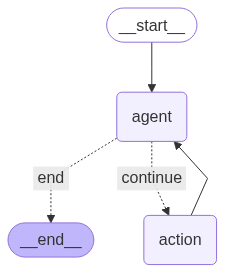

In [ ]:
from IPython.display import Image, display

try:
    display(Image(medical_graph_app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
from langchain_core.messages import HumanMessage

## Test Cases and Results

### Sample Doctor's Notes

In [ ]:
if GOOGLE_VERTEX_AI_MODE:
    config = {"configurable": {"thread_id": "1"}}
    query = suggestion_query

    input_message = HumanMessage(content=query)
    for event in medical_graph_app.stream(
        {"messages": [input_message]}, config, stream_mode="values"
    ):
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Suggest possible diseases and treatment based on the doctors notes : 
    Patient is John Baker. The patient's reason for the visit was due to cough and high temperature,
    which should be noted as fever and cough. Physical examination reveals no significant abnormalities
    in vital signs, with a blood pressure reading of 120/80 mmHg and a heart rate of 72 bpm. No visible
    edema or significant weight changes noted; the patient weighs 160 lbs and has a height of 5'10".
    The patient is in good health and prescribed antibiotics with instructions to take one tablet every
    8 hours with food. Additionally, the patient's next appointment is scheduled for a follow-up in 2 weeks

================================== Ai Message ==================================

Could you please extract the medical terms from the text provided?


### Multi-Session Testing

In [ ]:
if GOOGLE_VERTEX_AI_MODE:
    config = {"configurable": {"thread_id": "1"}}
    query = "What the situation with John Baker"

    input_message = HumanMessage(content=query)
    for event in medical_graph_app.stream(
        {"messages": [input_message]}, config, stream_mode="values"
    ):
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What the situation with John Baker
================================== Ai Message ==================================
Tool Calls:
  list_of_medical_terms (69bac1eb-f874-46aa-809b-3dfe72ea93fc)
 Call ID: 69bac1eb-f874-46aa-809b-3dfe72ea93fc
  Args:
    text: Patient is John Baker. The patient's reason for the visit was due to cough and high temperature, which should be noted as fever and cough. Physical examination reveals no significant abnormalities in vital signs, with a blood pressure reading of 120/80 mmHg and a heart rate of 72 bpm. No visible edema or significant weight changes noted; the patient weighs 160 lbs and has a height of 5'10". The patient is in good health and prescribed antibiotics with instructions to take one tablet every 8 hours with food. Additionally, the patient's next appointment is scheduled for a follow-up in 2 weeks
response_json: {'error': {'code': 403, 'message': 'SNOMEDCT_US v

**Memory Test**: Same thread ID should recall previous John Baker information and provide contextual updates. Different threads should not share the information in between.

#### New Patient Context

In [ ]:
if GOOGLE_VERTEX_AI_MODE:
    config = {"configurable": {"thread_id": "2"}}
    query = "What the situation with John Baker"

    input_message = HumanMessage(content=query)
    for event in medical_graph_app.stream(
        {"messages": [input_message]}, config, stream_mode="values"
    ):
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What the situation with John Baker
================================== Ai Message ==================================

I need more information to understand the situation with John Baker. Can you provide me with some text or medical terms related to his situation?


In [ ]:
data = [
    {
        "gender": "male",
        "age": 48,
        "systolic_blood_pressure": 135,
        "diastolic_blood_pressure": 85,
        "symptoms": "fatigue and occasional mild lower back discomfort",
        "notable_details": "increased frequency of nocturia",
    }
]

prompt_chat = f"""
You are a doctors assistant.\n\nPatients data: {data}.
Suggest potential illnesses, methods how to understand that's the true illness and further treatment.
Summarize the diagnostic methods to define next steps.
"""

In [ ]:
if GOOGLE_VERTEX_AI_MODE:
    config = {"configurable": {"thread_id": "3"}}
    query = prompt_chat

    input_message = HumanMessage(content=query)
    for event in medical_graph_app.stream(
        {"messages": [input_message]}, config, stream_mode="values"
    ):
        event["messages"][-1].pretty_print()

================================ Human Message =================================


You are a doctors assistant.

Patients data: [{'gender': 'male', 'age': 48, 'systolic_blood_pressure': 135, 'diastolic_blood_pressure': 85, 'symptoms': 'fatigue and occasional mild lower back discomfort', 'notable_details': 'increased frequency of nocturia'}].
Suggest potential illnesses, methods how to understand that's the true illness and further treatment.
Summarize the diagnostic methods to define next steps.

================================== Ai Message ==================================
Tool Calls:
  list_of_medical_terms (1ac189a6-bb2b-49f0-911b-c4c340f99998)
 Call ID: 1ac189a6-bb2b-49f0-911b-c4c340f99998
  Args:
    text: male, 48 years old, fatigue, occasional mild lower back discomfort, increased frequency of nocturia, systolic blood pressure 135, diastolic blood pressure 85
response_json: {'error': {'code': 403, 'message': 'SNOMEDCT_US vocabulary is not accessible from user location', 'statu

### Complex Case Analysis

#### Hypertension and Kidney Function Case

In [ ]:
kidney_scenario_data = load_json("kidney_scenario")

In [ ]:
kidney_scenario_data

{'initial_examination': {'CBC': {'Hemoglobin (Hb)': {'result': '13.8 g/dL',
    'reference_range': '13.5-17.5 g/dL',
    'notes': 'Normal'},
   'White Blood Cell Count (WBC)': {'result': '6,000 cells/mm³',
    'reference_range': '4,500-11,000 cells/mm³',
    'notes': 'Normal'},
   'Platelets (PLT)': {'result': '250,000 cells/mm³',
    'reference_range': '150,000-450,000 cells/mm³',
    'notes': 'Normal'}},
  'Serum Creatinine (SCr)': {'result': '1.2 mg/dL',
   'reference_range': '0.6-1.2 mg/dL',
   'notes': 'Upper limit of normal'},
  'Blood Urea Nitrogen (BUN)': {'result': '15 mg/dL',
   'reference_range': '7-20 mg/dL',
   'notes': 'Normal'},
  'Urinalysis (UA)': {'Protein': {'result': 'Trace',
    'reference_range': 'Negative',
    'notes': 'Slightly abnormal'},
   'Blood': {'result': 'Negative',
    'reference_range': 'Negative',
    'notes': 'Normal'}},
  'Blood Pressure (BP)': {'result': '135/85 mmHg',
   'reference_range': '<120/80 mmHg',
   'notes': 'Marginally elevated'}},
 'fo

In [ ]:
prompt_chat = f"""Below are the patients lab analysis: """
prompt_chat += str(kidney_scenario_data["initial_examination"])

In [ ]:
if GOOGLE_VERTEX_AI_MODE:
    config = {"configurable": {"thread_id": "3"}}

    input_message = HumanMessage(content=prompt_chat)
    for event in medical_graph_app.stream(
        {"messages": [input_message]}, config, stream_mode="values"
    ):
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Below are the patients lab analysis: {'CBC': {'Hemoglobin (Hb)': {'result': '13.8 g/dL', 'reference_range': '13.5-17.5 g/dL', 'notes': 'Normal'}, 'White Blood Cell Count (WBC)': {'result': '6,000 cells/mm³', 'reference_range': '4,500-11,000 cells/mm³', 'notes': 'Normal'}, 'Platelets (PLT)': {'result': '250,000 cells/mm³', 'reference_range': '150,000-450,000 cells/mm³', 'notes': 'Normal'}}, 'Serum Creatinine (SCr)': {'result': '1.2 mg/dL', 'reference_range': '0.6-1.2 mg/dL', 'notes': 'Upper limit of normal'}, 'Blood Urea Nitrogen (BUN)': {'result': '15 mg/dL', 'reference_range': '7-20 mg/dL', 'notes': 'Normal'}, 'Urinalysis (UA)': {'Protein': {'result': 'Trace', 'reference_range': 'Negative', 'notes': 'Slightly abnormal'}, 'Blood': {'result': 'Negative', 'reference_range': 'Negative', 'notes': 'Normal'}}, 'Blood Pressure (BP)': {'result': '135/85 mmHg', 'reference_range': '<120/80 mmHg', 'notes': 'Marginal

In [ ]:
prompt_chat = f"""Below are the patients follow-up analysis: """
prompt_chat += str(kidney_scenario_data["follow_up_examination"])

In [ ]:
if GOOGLE_VERTEX_AI_MODE:
    config = {"configurable": {"thread_id": "3"}}
    query = prompt_chat

    input_message = HumanMessage(content=query)
    for event in medical_graph_app.stream(
        {"messages": [input_message]}, config, stream_mode="values"
    ):
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Below are the patients follow-up analysis: {'CBC': {'Hemoglobin (Hb)': {'result': '12.5 g/dL', 'reference_range': '13.5-17.5 g/dL', 'notes': 'Slightly low'}, 'White Blood Cell Count (WBC)': {'result': '5,800 cells/mm³', 'reference_range': '4,500-11,000 cells/mm³', 'notes': 'Normal'}, 'Platelets (PLT)': {'result': '260,000 cells/mm³', 'reference_range': '150,000-450,000 cells/mm³', 'notes': 'Normal'}}, 'Serum Creatinine (SCr)': {'result': '1.7 mg/dL', 'reference_range': '0.6-1.2 mg/dL', 'notes': 'Elevated'}, 'Blood Urea Nitrogen (BUN)': {'result': '22 mg/dL', 'reference_range': '7-20 mg/dL', 'notes': 'Elevated'}, 'Urinalysis (UA)': {'Protein': {'result': '1+', 'reference_range': 'Negative', 'notes': 'Abnormal (proteinuria)'}, 'Blood': {'result': 'Trace', 'reference_range': 'Negative', 'notes': 'Slightly abnormal (microscopic hematuria)'}}, 'Blood Pressure (BP)': {'result': '140/90 mmHg', 'reference_range':

In [ ]:
from google.colab import auth as google_auth
import vertexai
from vertexai.preview.language_models import TextGenerationModel

if GOOGLE_VERTEX_AI_MODE:
    # MedLM models are only available in us-central1.
    vertexai.init(project=PROJECT_ID, location=LOCATION)

    parameters = {
        "candidate_count": 1,
        "max_output_tokens": 256,
        "temperature": 0.0,
        "top_k": 40,
        "top_p": 0.80,
    }

    model_instance = TextGenerationModel.from_pretrained("medlm-medium")

    suggestion_query = f"Suggest possible diseases and treatment based on the doctors notes : {doctors_notes_raw_input}"

/usr/local/lib/python3.11/dist-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


In [ ]:
MEDLM_MODE = False

In [ ]:
if GOOGLE_VERTEX_AI_MODE and MEDLM_MODE:
    response = model_instance.predict(suggestion_query, **parameters)

    print(f"Response from Model: {response.text}")

## RAG + SQL Database Integration

### Database Schema Design

In [ ]:
import sqlite3
import csv

# Create a connection to the SQLite database
conn = sqlite3.connect("patients.db")
cursor = conn.cursor()

#### Patient Information Table
**Purpose**: Core patient demographic and historical medical data storage.

In [ ]:
cursor.execute(
    """
    CREATE TABLE IF NOT EXISTS patients_info (
        Patient_ID INTEGER PRIMARY KEY,
        Name TEXT NOT NULL,
        Age INTEGER,
        Gender TEXT,
        Address TEXT,
        Phone_Number TEXT,
        Email TEXT,
        Medical_History TEXT,
        Family_Medical_History TEXT,
        Allergies TEXT
    );
"""
)

#### Patient Visits Table

**Purpose**: Track individual patient encounters with detailed visit information.

In [ ]:
cursor.execute(
    """
    CREATE TABLE IF NOT EXISTS patients_visits (
        Visit_ID INTEGER PRIMARY KEY AUTOINCREMENT,
        Patient_ID INTEGER NOT NULL,
        Name TEXT NOT NULL,
        Age INTEGER NOT NULL,
        Diagnosis TEXT NOT NULL,
        Allergies TEXT NOT NULL,
        Medications TEXT NOT NULL,
        Treatment_History TEXT NOT NULL,
        Test_Results TEXT NOT NULL,
        FOREIGN KEY (Patient_ID) REFERENCES patients (Patient_ID)
    );
"""
)

In [ ]:
# Load the data from the CSV files
import pandas as pd

df = pd.read_csv("./data/patients_synthetic_data.csv")
df.to_sql("patients_info", conn, if_exists="replace", index=False)

df = pd.read_csv("./data/patients_visits_data.csv")
df.to_sql("patients_visits", conn, if_exists="replace", index=False)

18

In [ ]:
cursor.execute("Select * from patients_info limit 1")
cursor.fetchall()

[(1,
  'Jane Smith',
  35,
  'Female',
  '123 Main St',
  '123-456-7890',
  'jane.smith@email.com',
  'Hypertension',
  'Obesity',
  'Tree nuts')]

In [ ]:
cursor.execute("Select * from patients_visits limit 1")
cursor.fetchall()

[(1,
  'John Doe',
  35,
  'Hypertension',
  'Tree nuts',
  'Lisinopril',
  'Regular check-ups',
  'Normal blood pressure',
  1,
  '2022-01-01',
  "Discussed patient's concerns and medical history, diagnosed with hypertension and prescribed Lisinopril.")]

In [ ]:
conn.close()

In [ ]:
SQL_RAG_MODE = True

### SQL Agent Implementation

#### Tool Configuration

In [ ]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0)

In [ ]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri(
    "sqlite:///patients.db",
    include_tables=["patients_info", "patients_visits"],
    sample_rows_in_table_info=2,
)  # view_support=True #

In [ ]:
from operator import itemgetter

from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

execute_query = QuerySQLDataBaseTool(db=db)
write_query = create_sql_query_chain(llm, db)
chain = write_query | execute_query

/tmp/ipython-input-58-2487666814.py:8: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  execute_query = QuerySQLDataBaseTool(db=db)


In [ ]:
if SQL_RAG_MODE:
    response = chain.invoke(
        {"question": "What patients over 40 are diagnosed with diabetes?"}
    )
    print(response)

Error: (sqlite3.OperationalError) near "To": syntax error
[SQL: To answer this question, we need to query the patients_visits table for patients over 40 who have been diagnosed with diabetes. Here's the SQL query:

SQLQuery: SELECT DISTINCT "Name", "Age", "Diagnosis"
FROM patients_visits
WHERE "Age" > 40 AND "Diagnosis" LIKE '%diabetes%'
LIMIT 5;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [ ]:
answer_prompt = PromptTemplate.from_template(
    """Given the following user question, corresponding SQL query, and SQL result, answer the user question.

Question: {question}
SQL Query: {query}
SQL Result: {result}
Answer: """
)

chain = (
    RunnablePassthrough.assign(query=write_query).assign(
        result=itemgetter("query") | execute_query
    )
    | answer_prompt
    | llm
    | StrOutputParser()
)

In [ ]:
if SQL_RAG_MODE:
    response = chain.invoke(
        {"question": "What patients over 40 are diagnosed with diabetes?"}
    )
    print(response)

I apologize, but I cannot provide a direct answer to the user's question based on the information given. The SQL query provided resulted in an error and did not execute successfully. The error message indicates there was a syntax error near "To" at the beginning of the query.

The intended SQL query appears to be:

```sql
SELECT DISTINCT "Name", "Age", "Diagnosis"
FROM patients_visits
WHERE "Age" > 40 AND "Diagnosis" LIKE '%diabetes%'
LIMIT 5;
```

This query would have returned the names, ages, and diagnoses of patients over 40 who have been diagnosed with diabetes, limited to 5 results. However, since the query didn't execute successfully, we don't have any data to answer the question "What patients over 40 are diagnosed with diabetes?"

To get an answer, the SQL query needs to be executed correctly against the patients_visits table. Once that's done, we would be able to provide specific information about patients over 40 diagnosed with diabetes.


#### ReAct SQL Agent

**Available Tools**:
- **Query Execution**: Run SQL queries safely
- **Schema Inspection**: Examine table structures
- **Data Validation**: Verify query results



In [ ]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

sql_toolkit = SQLDatabaseToolkit(db=db, llm=llm)
sql_tools = sql_toolkit.get_tools()

In [ ]:
sql_tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7c555c589d90>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7c555c589d90>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7c555c589d90>),
 QuerySQLCheckerTool(description='Use this tool to double check

In [ ]:
from langchain.agents import AgentExecutor, create_react_agent

template = """Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}"""

prompt = PromptTemplate.from_template(template)

agent = create_react_agent(llm, sql_tools, prompt)
agent_executor = AgentExecutor(
    agent=agent, tools=sql_tools, handle_parsing_errors=True, verbose=True
)

In [ ]:
if SQL_RAG_MODE:
    try:
        response = agent_executor.invoke(
            {"input": "What patients over 40 are diagnosed with diabetes?"}
        )
        print(response)

    except Exception as e:
        print(e)



> Entering new AgentExecutor chain...
To answer this question, I need to query the database for patients over 40 who have been diagnosed with diabetes. Let's start by checking the available tables in the database.

Action: sql_db_list_tables
Action Input: 
patients_info, patients_visitsNow that I know the available tables, I need to examine the schema of these tables to find the relevant information for our query.

Action: sql_db_schema
Action Input: patients_info, patients_visits

CREATE TABLE patients_info (
	"Patient_ID" INTEGER, 
	"Name" TEXT, 
	"Age" INTEGER, 
	"Gender" TEXT, 
	"Address" TEXT, 
	"Phone_Number" TEXT, 
	"Email" TEXT, 
	"Medical_History" TEXT, 
	"Family_Medical_History" TEXT, 
	"Allergies" TEXT
)

/*
2 rows from patients_info table:
Patient_ID	Name	Age	Gender	Address	Phone_Number	Email	Medical_History	Family_Medical_History	Allergies
1	Jane Smith	35	Female	123 Main St	123-456-7890	jane.smith@email.com	Hypertension	Obesity	Tree nuts
2	John Doe	28	Male	456 Elm St	987

In [ ]:
if SQL_RAG_MODE:
    response = agent_executor.invoke({"input": "What patients visited for an X-ray?"})
    print(response)



> Entering new AgentExecutor chain...
To answer this question, we need to query the database for patients who had X-ray procedures. Let's start by checking the available tables in the database.

Action: sql_db_list_tables
Action Input: 
patients_info, patients_visitsNow that we know the available tables, let's check the schema of these tables to find the relevant information.

Action: sql_db_schema
Action Input: patients_info, patients_visits

CREATE TABLE patients_info (
	"Patient_ID" INTEGER, 
	"Name" TEXT, 
	"Age" INTEGER, 
	"Gender" TEXT, 
	"Address" TEXT, 
	"Phone_Number" TEXT, 
	"Email" TEXT, 
	"Medical_History" TEXT, 
	"Family_Medical_History" TEXT, 
	"Allergies" TEXT
)

/*
2 rows from patients_info table:
Patient_ID	Name	Age	Gender	Address	Phone_Number	Email	Medical_History	Family_Medical_History	Allergies
1	Jane Smith	35	Female	123 Main St	123-456-7890	jane.smith@email.com	Hypertension	Obesity	Tree nuts
2	John Doe	28	Male	456 Elm St	987-654-3210	j.doe@email.com	Asthma	None	N

In [ ]:
from langchain_core.messages import SystemMessage

SQL_PREFIX = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables."""

system_sql_message = SystemMessage(content=SQL_PREFIX)

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent


agent_executor = create_react_agent(llm, sql_tools, prompt=system_sql_message)

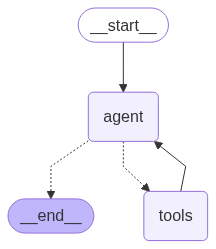

In [ ]:
from IPython.display import Image, display

try:
    display(Image(agent_executor.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Example Queries and Expected Results

**Safety Features**:
- **Read-Only Operations**: No DML statements allowed
- **Result Limiting**: Maximum 5 results to prevent overwhelming output
- **Column Selection**: Only relevant columns queried
- **Schema Validation**: Always inspect tables before querying

In [ ]:
if SQL_RAG_MODE:
    response = agent_executor.invoke(
        {
            "messages": [
                HumanMessage(
                    content="What patients over 40 are diagnosed with diabetes?"
                )
            ]
        }
    )
    print(response)

{'messages': [HumanMessage(content='What patients over 40 are diagnosed with diabetes?', additional_kwargs={}, response_metadata={}, id='8eb8b1c1-1f42-44e5-9876-14b5e59043e0'), AIMessage(content=[{'text': "Certainly! To answer your question about patients over 40 diagnosed with diabetes, I'll need to query the database. Let's start by looking at the available tables in the database.", 'type': 'text'}, {'id': 'toolu_01VNqmJ9XxTurWpx4HShkRLP', 'input': {'tool_input': ''}, 'name': 'sql_db_list_tables', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01QnDA7RT6mW6D3i5HbCzqxa', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1013, 'output_tokens': 96, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-3-5-sonnet-20240620'}, id='run--b41c7546-45ae-4913-9220-068bacb7f2e6-0', tool_calls=[{'name': 'sql_db_list_table

In [ ]:
if SQL_RAG_MODE:
    for s in agent_executor.stream(
        {
            "messages": [
                HumanMessage(
                    content="What patients over 40 are diagnosed with diabetes?"
                )
            ]
        }
    ):
        print(s)
        print("----")

{'agent': {'messages': [AIMessage(content=[{'text': "Certainly! To answer your question about patients over 40 diagnosed with diabetes, I'll need to query the database. Let's start by looking at the available tables in the database.", 'type': 'text'}, {'id': 'toolu_019LEvcCq61jPPaKUSN3A21A', 'input': {'tool_input': ''}, 'name': 'sql_db_list_tables', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_014dHsPLH3sW7aQsnDWBRMj8', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1013, 'output_tokens': 96, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-3-5-sonnet-20240620'}, id='run--0e6cb6d9-37bc-4102-b64d-5854a7d213ee-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {'tool_input': ''}, 'id': 'toolu_019LEvcCq61jPPaKUSN3A21A', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1013, 'output_tokens': 96,

In [ ]:
if SQL_RAG_MODE:
    for s in agent_executor.stream(
        {"messages": [HumanMessage(content="What patients visited for an X-ray?")]}
    ):
        print(s)
        print("----")

{'agent': {'messages': [AIMessage(content=[{'text': "To answer this question, I'll need to look at the database structure and then query the relevant tables. Let's start by listing the tables in the database.", 'type': 'text'}, {'id': 'toolu_017wMygZXM2iFrfBzmNVWwfT', 'input': {'tool_input': ''}, 'name': 'sql_db_list_tables', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01NmUUUBjv8EnPCuKRRebeSF', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1011, 'output_tokens': 90, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-3-5-sonnet-20240620'}, id='run--d5e03c95-059c-451a-aa12-ed6e3e36f635-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {'tool_input': ''}, 'id': 'toolu_017wMygZXM2iFrfBzmNVWwfT', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1011, 'output_tokens': 90, 'total_tokens': 1101, '

## Speech-to-Text Processing

### Overview
This section handles the conversion of audio medical notes into text format using OpenAI's Whisper model and provides tools for comparing transcription accuracy.

In [ ]:
from openai._client import OpenAI as OpenAI4Speech

**Purpose**: Configuration flags to control which speech recognition method to use:
- `WHISPER_MODE`: Enables OpenAI Whisper transcription
- `LOCAL_LLM_MODE`: Enables local medical LLM processing

In [ ]:
# Set to false to run whisper speech recognition
WHISPER_MODE = True
LOCAL_LLM_MODE = False

### Basic Whisper Transcription

In [ ]:
if WHISPER_MODE:
    audio_file = open("./data/audio/doctors_notes_001.mp3", "rb")
    client = OpenAI4Speech()
    transcript = client.audio.transcriptions.create(
        model="whisper-1", file=audio_file, response_format="text"
    )

    f = open("./data/transcripts/doctors_notes_transcript_001.txt", "w")
    f.write(transcript)
    f.close()

f = open("./data/transcripts/doctors_notes_transcript_001.txt", "r")
transcript = f.read()
f.close()

In [ ]:
from redlines import Redlines
import IPython

**What this does**:
- Opens the audio file containing doctor's notes
- Uses OpenAI's Whisper-1 model for transcription
- Saves the raw transcript to a text file for later processing


In [ ]:
f = open("./data/doctors_notes_original.txt", "r")
original_text = f.read()

### Transcript Quality Analysis

**Purpose**: This section compares the AI-generated transcript with the original text to assess transcription accuracy:
- Uses the `Redlines` library to highlight differences
- Creates a visual comparison showing added, removed, or changed text
- Helpful for quality assurance and identifying common transcription errors

In [ ]:
text_comparison = Redlines(original_text, transcript)

In [ ]:
# solution for colab based on https://github.com/googlecolab/colabtools/issues/322
# for regular notebook:
# from IPython.display import Markdown

from markdown import markdown

Markdown = lambda string: IPython.display.HTML(markdown(string))

In [ ]:
Markdown(text_comparison.output_markdown)

### LangChain-based Audio Processing Tool

**Key Features**:
- Wraps transcription functionality as a LangChain tool
- Can be used by AI agents in the multi-agent system
- Returns transcribed content directly for further processing


In [ ]:
from langchain.document_loaders.generic import GenericLoader
from langchain.document_loaders.parsers import OpenAIWhisperParser
from langchain_core.tools import tool


@tool
def load_and_transcribe_audio(filename, return_direct=True):
    """
    Speech to text tool.
    Used for loading an audio file by filename and transcribing it
    """
    loader = GenericLoader.from_filesystem(filename, parser=OpenAIWhisperParser())

    docs = loader.load()
    return docs[0].page_content


if WHISPER_MODE:
    lc_whisper_transcript = load_and_transcribe_audio(
        "./data/audio/doctors_notes_001.mp3"
    )

/tmp/ipython-input-81-3256406555.py:21: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  lc_whisper_transcript = load_and_transcribe_audio("./data/audio/doctors_notes_001.mp3")


Transcribing part 1!


In [ ]:
if WHISPER_MODE:
    text_comparison = Redlines(transcript, lc_whisper_transcript)
text_comparison = text_comparison if text_comparison else None
Markdown(text_comparison.output_markdown)

## Medical Text Correction

### Local Medical LLM Setup

**What this sets up**:
- Loads a specialized medical language model (JSL-MedLlama)
- Configures the model specifically for medical transcript correction
- Uses 8-bit quantization for memory efficiency
- The system prompt ensures conservative correction (only fixing obvious typos)

In [ ]:
from transformers import AutoTokenizer
import transformers
import torch

### Medical Transcript Correction Tool

**Parameters explained**:
- `max_new_tokens=256`: Limits response length
- `temperature=0.001`: Very low temperature for conservative, consistent corrections
- `top_k=5, top_p=0.95`: Restricts token selection for more focused corrections

In [ ]:
if LOCAL_LLM_MODE:
    model = "johnsnowlabs/JSL-MedLlama-3-8B-v17-8bits"
    tokenizer = AutoTokenizer.from_pretrained(model)
    messages = [
        {
            "role": "system",
            "content": """
          You are a medical assistant.
          The following transcript is taken from speech recognition and may contain typos.
          Do not add other words or remove them - only modify existent one, that are phonetically similar in case it's sensible.""",
        }
    ]

    js_pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        torch_dtype=torch.float16,
        device_map="auto",
    )

if LOCAL_LLM_MODE:

    @tool
    def call_medllama_audio(text):
        """
        Tool for autocorrection of medical audio transcripts. Fixes typos
        """
        _messages = messages + [{"role": "user", "content": text}]
        prompt = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        pipe = js_pipeline(
            prompt,
            max_new_tokens=256,
            do_sample=True,
            temperature=0.001,
            top_k=5,
            top_p=0.95,
        )
        return pipe[0]["generated_text"]


if LOCAL_LLM_MODE:
    fixed_transcript = call_medllama_audio(transcript)

In [ ]:
if LOCAL_LLM_MODE:
    text_comparison = Redlines(fixed_transcript, response_text)

In [ ]:
if LOCAL_LLM_MODE:
    Markdown(text_comparison.output_markdown)

### Cloud-based Text Correction

**Multiple Model Comparison**: The notebook tests several models for medical transcript correction

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt_template = """
You are a medical assistant.
The following transcript is taken from speech recognition and may contain typos.
Do not add other words or remove them - only modify existent one, that are phonetically similar in case it's sensible.
Transcript text: {text}
"""

prompt = PromptTemplate.from_template(prompt_template)

In [ ]:
if GOOGLE_VERTEX_AI_MODE:
    llm = VertexAI(model_name="gemini-1.5-pro", max_output_tokens=8042, temperature=0)
    chain = prompt | llm | StrOutputParser()
    vertex_ai_response = chain.invoke({"text": transcript})

In [ ]:
if GOOGLE_VERTEX_AI_MODE:
    text_comparison = Redlines(transcript, vertex_ai_response)
    Markdown(text_comparison.output_markdown)

In [ ]:
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0)
chain = prompt | llm | StrOutputParser()
claude_35_response = chain.invoke({"text": transcript})

In [ ]:
text_comparison = Redlines(original_text, claude_35_response)
Markdown(text_comparison.output_markdown)

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
chain = prompt | llm | StrOutputParser()
gpt_4o_mini_response = chain.invoke({"text": transcript})

In [ ]:
text_comparison = Redlines(transcript, gpt_4o_mini_response)
Markdown(text_comparison.output_markdown)

In [ ]:
text_comparison = Redlines(original_text, gpt_4o_mini_response)
Markdown(text_comparison.output_markdown)

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)
chain = prompt | llm | StrOutputParser()
gpt_4o_response = chain.invoke({"text": transcript})

In [ ]:
text_comparison = Redlines(transcript, gpt_4o_response)
Markdown(text_comparison.output_markdown)

In [ ]:
text_comparison = Redlines(original_text, gpt_4o_response)
Markdown(text_comparison.output_markdown)

## Text Summarization

### Medical Summarization Setup

**Configuration Notes**:
- Uses specialized medical summarization model when enabled
- Falls back to returning original text when disabled
- Configured for concise summaries (50-100 words)

In [ ]:
SUMMARIZATION_MODE = True

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="Falconsai/medical_summarization")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


In [ ]:
if SUMMARIZATION_MODE:
    # https://nlp.johnsnowlabs.com/2023/03/25/summarizer_clinical_jsl.html
    summary = summarizer(transcript, max_new_tokens=100, min_length=50, do_sample=False)

    print()
    print()
    print(summary[0]["summary_text"])

Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)




a 38-year - old patient is noticing distant erythema along the medical aspect of the left lower extremity , suggestive of cellulitis . palpation revealed a palpable cord indicative of thrombophlebitis extending proximately from the medial malleolus . oscillation of the chest disclosed bilateral basal crackles , potentially signifying early pulmonary e


In [ ]:
from typing import Annotated, Literal, TypedDict, List
from langchain_core.messages import HumanMessage
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

### Advanced Summarization Prompt

**Methodology**: This approach uses a question-answer framework to ensure comprehensive summarization by:
- Forcing identification of key themes
- Ensuring important details aren't lost
- Providing structured, analytical summaries


In [ ]:
summarization_prompt = """
1.) Analyze the input text and generate 5 essential questions that, when answered, capture the main points and core meaning of the text.

2.) When formulating your questions:
 a. Address the central theme or argument
 b. Identify key supporting ideas
 c. Highlight important facts or evidence
 d. Reveal the author's purpose or perspective
 e. Explore any significant implications or conclusions.

3.) Answer all of your generated questions one-by-one in detail.
"""

In [ ]:
@tool
def summarize_medical_text(text):
    """
    Summarization tool.
    Used for summarizing doctors medical notes
    """
    try:
        # https://nlp.johnsnowlabs.com/2023/03/25/summarizer_clinical_jsl.html
        summary = summarizer(text, max_new_tokens=100, min_length=50, do_sample=False)
        return summary[0]["summary_text"]

    except:
        # 1. Define the Prompt Template
        prompt = ChatPromptTemplate.from_messages(
            [
                ("system", summarization_prompt),
                ("human", "Medical Text:\n{text}\n\nConcise Medical Summary:"),
            ]
        )

        # 2. Define the Output Parser
        output_parser = StrOutputParser()

        # 3. Construct the LCEL Chain
        # This chain takes the input 'text', formats it into the prompt,
        # sends it to the LLM, and then parses the LLM's output into a string.
        medical_summarization_chain = prompt | llm | output_parser

        return medical_summarization_chain.invoke({"text": text})

## Report Generation System

**Complete Workflow**:
1. Extracts structured data from raw notes if needed
2. Looks up patient information in database
3. Merges extracted data with patient records and system data
4. Generates both Markdown and PDF versions of the report
5. Handles missing patient scenarios gracefully

### Patient Data Management

**Functionality**:
- Loads patient database from CSV
- Handles title prefixes (Mr., Mrs., Ms.) automatically
- Returns patient data as dictionary for easy template filling

In [ ]:
df = pd.read_csv("./data/patients_synthetic_data.csv")


def find_patient_by_name(name_to_find):
    if "Mr." in name_to_find or "Mrs." in name_to_find or "Ms." in name_to_find:
        name_to_find = (
            name_to_find.replace("Mr.", "").replace("Mrs.", "").replace("Ms.", "")
        )
    patient = df[df["Name"].str.contains(name_to_find)]
    if not patient.empty:
        return patient.to_dict(orient="records")[0]
    return None

### Template Processing Functions

**Purpose**: Ensures all template fields are filled, using "-" for missing data to maintain professional report formatting.

In [ ]:
# Function to set empty default values
def replace_placeholders(template, data):
    def default(key):
        return data.get(key, "-")

    return template.format(
        patient_id=default("patient_id"),
        patient_name=default("patient_name"),
        date=default("date"),
        time=default("time"),
        hospital=default("hospital"),
        doctor_name=default("doctor_name"),
        location=default("location"),
        contact=default("contact"),
        reason_for_visit_patient=default("reason_for_visit_patient"),
        reason_for_visit_doctor=default("reason_for_visit_doctor"),
        doctor_comment=default("doctor_comment"),
        age=default("age"),
        weight=default("weight"),
        height=default("height"),
        blood_pressure=default("blood_pressure"),
        heart_rate=default("heart_rate"),
        prescription=default("prescription"),
        prescription_instruction=default("prescription_instruction"),
        next_appointment_reason=default("next_appointment_reason"),
    )

### Data Mapping and System Configuration

**Data Processing**:
- Maps CSV column names to template field names
- Automatically adds current date/time and hospital information
- Ensures consistent data structure across the system


In [ ]:
def apply_patient_mapping(_dict):
    _dict["patient_name"] = _dict.pop("Name")
    _dict["patient_id"] = _dict.pop("Patient_ID")
    _dict["age"] = _dict.pop("Age")
    _dict["location"] = _dict.pop("Address")
    _dict["contact"] = _dict.pop("Phone_Number")
    return _dict

In [ ]:
from datetime import datetime

current_datetime = datetime.now()
system_data = {
    "date": current_datetime.strftime("%Y-%m-%d"),
    "time": current_datetime.strftime("%I:%M %p"),
    "hospital": "St. Mungo's Hospital",
    "doctor_name": "Dr. Miriam Strout",
}

In [ ]:
output_filename = "./results/doctors_visit_report"
template_filename = "./data/doctors_visit_template.md"
schema = load_json("doctors_visit_schema")
markdown_template = load_markdown(template_filename)

In [ ]:
pdf = MarkdownPdf()
pdf.meta["title"] = "Doctor visit template blank"
pdf.add_section(Section(markdown_template, toc=False))
pdf.save(f"{output_filename}_template.pdf")

### Structured Data Extraction Tool

**Key Feature**: Uses structured output to ensure the LLM returns data in a specific format that matches the report template schema.

In [ ]:
@tool
def extract_data_from_doctors_notes(
    doctors_notes_raw_input, return_direct=True
) -> dict:
    """
    Extract data from doctors notes and save as structured dictionary
    """
    structured_llm = llm.with_structured_output(schema)
    result = structured_llm.invoke(doctors_notes_raw_input)
    return result

In [ ]:
REPORT_GENERATION_MODE = True

In [ ]:
result = None
if REPORT_GENERATION_MODE:
    result = extract_data_from_doctors_notes(doctors_notes_raw_input)

In [ ]:
result

{'patient_id': 'JB20231012',
 'patient_name': 'John Baker',
 'reason_for_visit_patient': 'Cough and high temperature',
 'reason_for_visit_doctor': 'Fever and cough',
 'doctor_comment': 'Patient is in good health with no significant abnormalities in vital signs. Prescribed antibiotics to address the symptoms.',
 'weight': '160 lbs',
 'height': '5\'10"',
 'blood_pressure': '120/80 mmHg',
 'heart_rate': '72 bpm',
 'prescription': 'Antibiotics',
 'prescription_instruction': 'Take one tablet every 8 hours with food.',
 'next_appointment_reason': 'Follow-up in 2 weeks to assess recovery and ensure symptoms have resolved.'}

### Complete Report Generation

In [ ]:
from langchain.tools import tool
from typing import (
    Annotated,
)  # Important for adding descriptions to arguments for the LLM


@tool
def generate_report(
    result: Annotated[
        dict,
        "A comprehensive dictionary containing all extracted medical data from "
        "doctor's notes. This *must* include the 'patient_name' key. "
        "Other expected keys are 'diagnosis', 'medications', 'visit_date', "
        "and any other relevant patient information.",
    ],
    return_direct: Annotated[
        bool,
        "Set to True if the tool's output should be returned directly to the user "
        "without further LLM processing. Defaults to True.",
    ] = True,  # Explicitly setting default here for clarity, though it's already there
) -> None:
    """
    Generates a structured medical report for a patient's visit.

    This tool takes a dictionary of extracted medical data and uses it to
    create a formatted report in both Markdown and PDF formats.
    It relies on accurately provided patient information to find existing records
    and generate a complete and personalized report.
    """
    try:
        print("result")
        print(result)

        # Add more robust validation here, especially for crucial keys
        if "patient_name" not in result:
            raise ValueError(
                "The 'result' dictionary must contain a 'patient_name' key."
            )

        if (
            type(result) == str
        ):  # This suggests the agent might be passing a string sometimes
            print("Warning: 'result' was a string, attempting data extraction.")
            result = extract_data_from_doctors_notes(result)

        # Find the patient by name
        patient_data = find_patient_by_name(result["patient_name"])

        # Check if the patient was found and run report generation
        if patient_data:
            patient_data = apply_patient_mapping(patient_data)
            result.update(patient_data)
            result.update(system_data)

            result = {k: result[k] for k in result if not pd.isna(result[k])}
            markdown_report = replace_placeholders(markdown_template, result)

            try:
                # Save markdown file
                save_markdown(
                    f"{output_filename}_{result['patient_name']}.md", markdown_report
                )
            except Exception as e:
                print(f"save_markdown failed: {e}")

            pdf = MarkdownPdf()  # Assuming MarkdownPdf, Section imported
            pdf.meta["title"] = "Doctor visit blank"
            pdf.add_section(Section(markdown_report, toc=False))
            pdf.save(f"{output_filename}_{result['patient_name']}.pdf")
        else:
            print("Patient not found.")
    except Exception as e:
        print(f"An error occurred in generate_report: {e}")
        save_json(result, "fallback.json")
        raise ValueError(
            f"Failed to generate report due to: {e}. "
            f"Check the 'result' dictionary for completeness and correctness. "
            f"Specifically, ensure 'patient_name' is present and valid."
        )

In [ ]:
if REPORT_GENERATION_MODE:
    generate_report.invoke({"result": result})

result
{'patient_id': 'JB20231012', 'patient_name': 'John Baker', 'reason_for_visit_patient': 'Cough and high temperature', 'reason_for_visit_doctor': 'Fever and cough', 'doctor_comment': 'Patient is in good health with no significant abnormalities in vital signs. Prescribed antibiotics to address the symptoms.', 'weight': '160 lbs', 'height': '5\'10"', 'blood_pressure': '120/80 mmHg', 'heart_rate': '72 bpm', 'prescription': 'Antibiotics', 'prescription_instruction': 'Take one tablet every 8 hours with food.', 'next_appointment_reason': 'Follow-up in 2 weeks to assess recovery and ensure symptoms have resolved.'}


## Multi-Agent Architecture

### Research Tools Setup

**Research Integration**: Sets up access to multiple academic databases for medical research:
- PubMed: Medical literature database
- Semantic Scholar: Academic paper search
- Scopus: Citation database (requires API key)

In [ ]:
from langchain_core.prompts import PromptTemplate, MessagesPlaceholder
from langchain_community.tools.pubmed.tool import PubmedQueryRun
from langchain_community.tools.semanticscholar.tool import SemanticScholarQueryRun
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.tools import Tool
import requests

### SCOPUS Query Generation

**Smart Query Builder**: This template teaches the LLM how to construct proper SCOPUS API queries with:
- Proper field restrictions
- Boolean logic
- Date filtering
- Geographic restrictions
- Medical subject area filtering

In [ ]:
# int(results['search-results']['opensearch:totalResults'])

API_KEY = os.environ["SCOPUS_API_KEY"]

generate_scopus_url_template = """
    Generate a SCOPUS API query URL based on the user's request.

    Instructions:
    - Use Boolean operators (AND, OR, AND NOT) to combine keywords.
    - URL-encode the query string.
    - Use field restriction codes to search specific fields.
    - Use proximity operators (pre/n, w/n) for proximity searches.
    - Use wildcards (? for single character, * for multiple characters) for flexible searches.
    - Follow order of precedence rules: OR > AND > AND NOT.
    - Enclose exact phrases in braces {{}}.
    - Use double quotation marks "" for approximate phrases.

    Sorting:
        If user askes for most cited papers - use `sort=-citedby-count`
        If most recent or latest papers - use `sort=-coverDate`

    If the number of output or count isn't mentioned, set as count=10

    If author is mentioned - use the following filtering (for Ivan Reznikov):
        AUTHOR-NAME(Reznikov, I)

    If affilation is mentioned - use the following filtering (for Google):
        AFFIL(Google)

    If a data range is mentioned - use the following rules:
        before 2000: date=0-2020
        2000-2003: date=2000-2003
        after 2000: date=2000-3000

    Categorical keywords and their explanations:
    - DOCTYPE: Document Type (e.g.,
        "ar": "Article",
        "bk": "Book",
        "cp": "Conference Paper",
        "re": "Review",
        "ed": "Editorial",
        "le": "Letter",
        "no": "Note",
        "pr": "Press Release",
        "sh": "Short Survey")

    If Subjarea can be extracted - extract it and use SUBJAREA: subjarea(ENVI)
    Else use TITLE-ABS-KEY: TITLE-ABS-KEY(renewable%20energy)

    - SUBJAREA: Subject Area (
        "AGRI": "Agricultural and Biological Sciences",
        "ARTS": "Arts and Humanities",
        "BIOC": "Biochemistry, Genetics and Molecular Biology",
        "BUSI": "Business, Management and Accounting",
        "CENG": "Chemical Engineering",
        "CHEM": "Chemistry",
        "COMP": "Computer Science",
        "DECI": "Decision Sciences",
        "DENT": "Dentistry",
        "EART": "Earth and Planetary Sciences",
        "ECON": "Economics, Econometrics and Finance",
        "ENER": "Energy",
        "ENGI": "Engineering",
        "ENVI": "Environmental Science",
        "HEAL": "Health Professions",
        "IMMU": "Immunology and Microbiology",
        "MATE": "Materials Science",
        "MATH": "Mathematics",
        "MEDI": "Medicine",
        "NEUR": "Neuroscience",
        "NURS": "Nursing",
        "PHAR": "Pharmacology, Toxicology and Pharmaceutics",
        "PHYS": "Physics and Astronomy",
        "PSYC": "Psychology",
        "SOCI": "Social Sciences",
        "VETE": "Veterinary",
        "MULT": "Multidisciplinary"
    )
    - AFFILCOUNTRY: Affiliation Country (e.g., USA, China, Japan)
    - LANGUAGE: Language of the document (e.g., English, French, German)
    - OPENACCESS: Open Access status (1 = Open Access, 0 = Subscription-based)

    Examples:
    User request: "list 10 most cited papers on quantum computing"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(quantum%20computing)&sort=-citedby-count&count=10&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find papers on climate change from 2020 to 2023 in Environmental Science"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(climate%20change)%20AND%20subjarea(ENVI)&date=2020-2023&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find 5 most recent papers on langchain in Computer Science"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(langchain)%20AND%20subjarea(COMP)&sort=-coverDate&count=5&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find 20 most recent papers on gene editing by author Li Q."
    URL query: https://api.elsevier.com/content/search/scopus?query=AUTHOR-NAME(Li,Q)%20AND%20all(gene%20editing)&sort=-coverDate&count=20&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "list recent papers by author John Doe in chemistry"
    URL query: https://api.elsevier.com/content/search/scopus?query=authname(John%20Doe)%20AND%20subjarea(CHEM)&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "list papers on renewable energy published in 2021 with wind and solar in abstract"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(renewable%20energy)%20AND%20abs(wind%20solar)&date=2021&subj=ENER&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "list papers on nanotechnology from stanford"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(nanotechnology)%20AND%20AFFIL(stanford)&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find all papers by openai"
    URL query: https://api.elsevier.com/content/search/scopus?query=(openai)&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find recent papers that include aspirin and water"
    URL query: https://api.elsevier.com/content/search/scopus?query=CHEM(aspirin&20water)&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find 20 latest books on renewable energy"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(renewable%20energy)%20AND%20doctype(bk)&sort=-coverDate&count=20&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "return data regarding 10.1007/s00202-004-0261-3 article"
    URL query: https://api.elsevier.com/content/search/scopus?query=DOI(10.1007/s00202-004-0261-3)&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "return data regarding 9780123456789 isbn"
    URL query: https://api.elsevier.com/content/search/scopus?query=ISBN(9780123456789)&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "list articles with chatgpt keyword in french"
    URL query: https://api.elsevier.com/content/search/scopus?query=key(chatgpt)%20AND%20Language(french)&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find 20 latest open access articles in large language models"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(large%20language%20models)%20AND%20openaccess(1)&sort=-coverDate&count=20&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find papers that cite Attention Is All You Need"
    URL query: https://api.elsevier.com/content/search/scopus?query=ref(Attention%20Is%20All%20You%20Need)&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "return data about GPT-4 Technical Report paper"
    URL query: https://api.elsevier.com/content/search/scopus?query=title(GPT-4%20Technical%20Report)&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find articles in artificial intelligence in medicine before 2000"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(artificial%20intelligence)%20AND%20subjarea(MEDI)&date(0-2000)&sort=-coverDate&count=20&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find papers on cancer research from China in Medicine"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(cancer%20research)%20AND%20AFFILCOUNTRY(China)&subj=MEDI&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: {user_query}
    URL query:
"""

generate_scopus_url_template = generate_scopus_url_template.replace(
    "{{API_KEY}}", API_KEY
)
generate_scopus_url_prompt = PromptTemplate.from_template(generate_scopus_url_template)

chain = (
    {"user_query": RunnablePassthrough()}
    | generate_scopus_url_prompt
    | llm
    | StrOutputParser()
)

generate_scopus_query_tool = Tool(
    name="generate_scopus_url",
    func=chain.invoke,
    description="A tool to generate a scopus url to retrieve data",
)


@tool("request_url")
def request_url(url):
    "Tool for querying url"
    headers = {
        "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
        "accept-language": "en-US,en;q=0.9,ru;q=0.8",
        "cache-control": "max-age=0",
        # 'cookie': 'AMCVS_4D6368F454EC41940A4C98A6%40AdobeOrg=1; __cf_bm=vyLwhM.5yYUJUs8.uPGsa8PDR4AuQguVM2id9mVp.ks-1716273084-1.0.1.1-dffFtQVqLTeuRYW_lSnIVfEzbgIUDOehw3nmnzJt0ZbsHND3.1fvKWtwMF3pzMwp.Y7BenR.ZdplnC7eSi4bTw; test=cookie; AMCV_4D6368F454EC41940A4C98A6%40AdobeOrg=-408604571%7CMCIDTS%7C19864%7CMCMID%7C32223060440167140023422064896007367729%7CMCAID%7CNONE%7CMCOPTOUT-1716280359s%7CNONE%7CvVersion%7C4.6.0',
        "priority": "u=0, i",
        #'referer': 'https://colab.research.google.com/',
        "sec-ch-ua": '"Chromium";v="124", "Google Chrome";v="124", "Not-A.Brand";v="99"',
        "sec-ch-ua-mobile": "?0",
        "sec-ch-ua-platform": '"Linux"',
        "sec-fetch-dest": "document",
        "sec-fetch-mode": "navigate",
        "sec-fetch-site": "cross-site",
        "sec-fetch-user": "?1",
        "upgrade-insecure-requests": "1",
        "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
    }

    response = requests.get(
        url,
        headers=headers,
    )

    if response.status_code == 200:
        return response.json()["search-results"]["entry"]
    else:
        print(response.status_code, response.text)
        return None

In [ ]:
from langchain.agents import load_tools

research_query_tools = load_tools(
    ["arxiv"],
) + [
    PubmedQueryRun(),
    SemanticScholarQueryRun(),
    generate_scopus_query_tool,
    request_url,
]

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### Team State Management

**State Management**: The `TeamGraphState` tracks:
- **messages**: Conversation history between agents
- **team_members**: Available agents and their capabilities
- **next**: Supervisor's decision on which agent to activate
- **current_files**: Shared workspace status

In [ ]:
import operator
from pathlib import Path
import functools
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage, BaseMessage, trim_messages

WORKING_DIRECTORY = Path("results")

trimmer = trim_messages(
    max_tokens=100000,
    strategy="last",
    token_counter=llm,
    include_system=True,
)


# Document writing team graph state
class TeamGraphState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This tracks the shared directory state
    current_files: str

### Supervisor Agent Creation

**Supervisor Logic**: Creates an intelligent router that:
- Analyzes conversation context
- Decides which specialized agent should act next
- Can terminate the workflow when complete
- Uses function calling to ensure structured decisions

In [ ]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | trimmer
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

### Agent Node Creation

**Context Awareness**: The prelude function ensures each agent knows:
- What files have been created by the team
- Current state of the working directory
- Previous work completed by other agents


In [ ]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }


# This will be run before each worker agent begins work
# It makes it so they are more aware of the current state
# of the working directory.
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


### Specialized Agents

**Agent Specialization**:
- **SpeechTranscriber**: Handles audio-to-text conversion
- **DatabaseEngineer**: Manages patient data queries
- **ReportGenerator**: Creates structured medical reports

In [ ]:
transcribe_agent = create_react_agent(llm, tools=[load_and_transcribe_audio])
context_aware_transcribe_agent = prelude | transcribe_agent
transcribe_node = functools.partial(
    agent_node, agent=context_aware_transcribe_agent, name="SpeechTranscriber"
)

db_agent = create_react_agent(llm, sql_tools, prompt=system_sql_message)
context_aware_db_agent = prelude | db_agent
db_node = functools.partial(
    agent_node, agent=context_aware_db_agent, name="DatabaseEngineer"
)

report_agent = create_react_agent(llm, tools=[generate_report])
context_aware_report_agent = prelude | report_agent
report_node = functools.partial(
    agent_node, agent=context_aware_report_agent, name="ReportGenerator"
)

"""file_saving_agent = create_react_agent(
    llm, tools=[write_document, read_document, read_json, write_json]
)

context_aware_file_saving_agent = prelude | file_saving_agent
file_saving_node = functools.partial(
    agent_node, agent=context_aware_file_saving_agent, name="ReadWriteFiles"
)"""

'file_saving_agent = create_react_agent(\n    llm, tools=[write_document, read_document, read_json, write_json]\n)\n\ncontext_aware_file_saving_agent = prelude | file_saving_agent\nfile_saving_node = functools.partial(\n    agent_node, agent=context_aware_file_saving_agent, name="ReadWriteFiles"\n)'

### Report Generation Team
**Workflow Management**: The supervisor follows a clear workflow:
1. Audio transcription
2. Database lookup
3. Data structuring
4. Report generation
5. Error handling and graceful degradation

In [ ]:
doc_writing_supervisor = create_team_supervisor(
    llm,
    """
    You are a supervisor tasked with managing a conversation between the
    following workers:  {team_members}. Given the following user request,
    respond with the worker to act next. Each worker will perform a
    task and respond with their results and status. When finished,
    respond with FINISH.
    In order to create a report
    1. transcribe the audio report
    2. match it with the data from the database
    3. parse data into predefineied format
    4. generate a report based on the extracted dictionary data
    If some fields are required fields are empty - replace with a '-' symbol.
    Generate the final report even if some errors occur.
    If you're getting stuck for some time - no problem - call FINISH.
    """,
    ["SpeechTranscriber", "DatabaseEngineer", "ReportGenerator"],  # "ReadWriteFiles"],
)

/tmp/ipython-input-121-3029816938.py:35: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


### Graph Construction

**Graph Architecture**:
- All agents report back to the supervisor
- Supervisor makes routing decisions based on workflow state
- Flexible routing allows for dynamic workflow adaptation

In [ ]:
# Create the graph here:
# Note that we have unrolled the loop for the sake of this doc
report_graph = StateGraph(TeamGraphState)
report_graph.add_node("SpeechTranscriber", transcribe_node)
report_graph.add_node("DatabaseEngineer", db_node)
# report_graph.add_node("ParsingAgent", parsing_node)
report_graph.add_node("ReportGenerator", report_node)
# report_graph.add_node("ReadWriteFiles", file_saving_node)
report_graph.add_node("supervisor", doc_writing_supervisor)

# Add the edges that always occur
report_graph.add_edge("SpeechTranscriber", "supervisor")
report_graph.add_edge("DatabaseEngineer", "supervisor")
# report_graph.add_edge("ParsingAgent", "supervisor")
report_graph.add_edge("ReportGenerator", "supervisor")
# report_graph.add_edge("ReadWriteFiles", "supervisor")

# Add the edges where routing applies
report_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "SpeechTranscriber": "SpeechTranscriber",
        "DatabaseEngineer": "DatabaseEngineer",
        #        "ParsingAgent": "ParsingAgent",
        "ReportGenerator": "ReportGenerator",
        #        "ReadWriteFiles": "ReadWriteFiles",
        "FINISH": END,
    },
)

report_graph.add_edge(START, "supervisor")
chain = report_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
report_chain = (
    functools.partial(enter_chain, members=report_graph.nodes) | report_graph.compile()
)

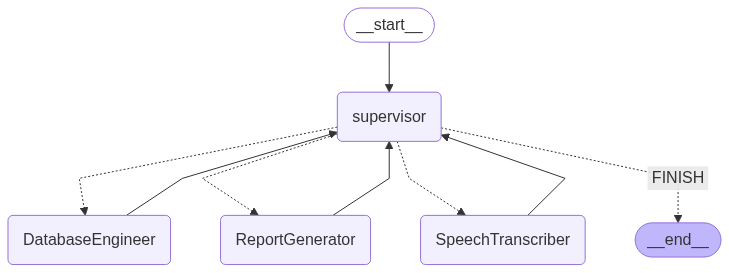

In [ ]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
for s in report_chain.stream(
    "Generate report of the patients visit from /content/data/audio/doctors_notes_001.mp3?",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'SpeechTranscriber'}}
---
Transcribing part 1!
{'SpeechTranscriber': {'messages': [HumanMessage(content="### Patient Visit Report\n\n**Patient Information:**\n- **Name:** Mr. Doe\n- **Age:** 38 years\n\n**Clinical Findings:**\n- **Skin Examination:** \n  - Notable distant erythema along the medial aspect of the left lower extremity, suggestive of cellulitis.\n  - Palpation revealed a palpable cord indicative of thrombophlebitis, extending approximately from the medial malleolus.\n\n- **Chest Examination:**\n  - Osculation of the chest disclosed bilateral basal crackles, potentially signifying early pulmonary edema.\n\n**Medical History:**\n- The patient has a history of noncompliance with antihypertensive therapy.\n- Anamnesis indicates intermittent claudication, raising concerns for underlying peripheral arterial disease.\n\n**Assessment:**\n- The findings suggest a need for further evaluation and management of cellulitis, thrombophlebitis, and potential pulmon

In [ ]:
suggestion_query = f"Suggest possible diseases and treatment based on the doctors notes : {doctors_notes_raw_input}"

In [ ]:
med_llm_tools = [list_of_medical_terms, dummy_medical_llm]

## Research and Brainstorming Tools

### Brainstorming Team Setup

**Brainstorming Capabilities**:
- **Research Agent**: Queries academic databases for relevant studies
- **LLM Agent**: Provides AI-powered medical insights
- **Summarization Agent**: Distills information into actionable insights

In [ ]:
"""brainstorming_research_node = ToolNode(research_query_tools, name="BrainstormingResercher")
brainstorming_llm_node = ToolNode(med_llm_tools, name="BrainstormingLLM")"""

'brainstorming_research_node = ToolNode(research_query_tools, name="BrainstormingResercher")\nbrainstorming_llm_node = ToolNode(med_llm_tools, name="BrainstormingLLM")'

In [ ]:
brainstorming_research_agent = create_react_agent(llm, tools=research_query_tools)
context_aware_brainstorming_research_agent = prelude | brainstorming_research_agent
brainstorming_research_node = functools.partial(
    agent_node,
    agent=context_aware_brainstorming_research_agent,
    name="BrainstormingResercher",
)

brainstorming_llm_agent = create_react_agent(llm, tools=[dummy_medical_llm])
context_aware_brainstorming_llm_agent = prelude | brainstorming_llm_agent
brainstorming_llm_node = functools.partial(
    agent_node,
    agent=context_aware_brainstorming_llm_agent,
    name="BrainstormingResercher",
)

summarization_agent = create_react_agent(llm, tools=[summarize_medical_text])
context_aware_summarization_agent = prelude | summarization_agent
summarization_node = functools.partial(
    agent_node, agent=context_aware_summarization_agent, name="SummarizationAgent"
)

In [ ]:
brainstorming_writing_supervisor = create_team_supervisor(
    llm,
    """
    You are a supervisor tasked with managing a conversation between the
    following workers:  {team_members}. Given the following user request,
    respond with the worker to act next. Each worker will perform a
    task and respond with their results and status. When finished,
    respond with FINISH.
    Unless specified, do not run the same tool twice in a row!!
    Summarize the passed information first, than call either research or llm
    assistant to provide the final answer.
    If you're getting stuck with same error for some time - call FINISH.
    """,
    ["BrainstormingResercher", "BrainstormingLLM", "SummarizationAgent"],
)

In [ ]:
# Create the graph here:
# Note that we have unrolled the loop for the sake of this doc
brainstorm_graph = StateGraph(TeamGraphState)
brainstorm_graph.add_node("BrainstormingResercher", brainstorming_research_node)
brainstorm_graph.add_node("BrainstormingLLM", brainstorming_llm_node)
brainstorm_graph.add_node("SummarizationAgent", report_node)
brainstorm_graph.add_node("supervisor", brainstorming_writing_supervisor)

# Add the edges that always occur
brainstorm_graph.add_edge("BrainstormingResercher", "supervisor")
brainstorm_graph.add_edge("BrainstormingLLM", "supervisor")
brainstorm_graph.add_edge("SummarizationAgent", "supervisor")

# Add the edges where routing applies
brainstorm_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "BrainstormingResercher": "BrainstormingResercher",
        "BrainstormingLLM": "BrainstormingLLM",
        "SummarizationAgent": "SummarizationAgent",
        "FINISH": END,
    },
)

brainstorm_graph.add_edge(START, "supervisor")
chain = brainstorm_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
brainstorm_chain = (
    functools.partial(enter_chain, members=brainstorm_graph.nodes)
    | brainstorm_graph.compile()
)

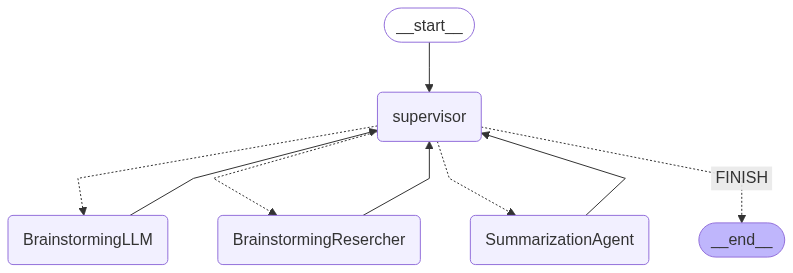

In [ ]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
suggestion_query

'Suggest possible diseases and treatment based on the doctors notes : \n    Patient is John Baker. The patient\'s reason for the visit was due to cough and high temperature,\n    which should be noted as fever and cough. Physical examination reveals no significant abnormalities\n    in vital signs, with a blood pressure reading of 120/80 mmHg and a heart rate of 72 bpm. No visible\n    edema or significant weight changes noted; the patient weighs 160 lbs and has a height of 5\'10".\n    The patient is in good health and prescribed antibiotics with instructions to take one tablet every\n    8 hours with food. Additionally, the patient\'s next appointment is scheduled for a follow-up in 2 weeks\n'

In [ ]:
try:
    for s in brainstorm_chain.stream(suggestion_query, {"recursion_limit": 10}):
        if "__end__" not in s:
            print(s)
            print("---")

except Exception as e:
    print(e)

{'supervisor': {'next': 'SummarizationAgent'}}
---
{'SummarizationAgent': {'messages': [HumanMessage(content="Based on the doctor's notes regarding John Baker's symptoms of cough and high temperature (fever), along with the physical examination findings, here are some possible diseases and their corresponding treatments:\n\n### Possible Diseases:\n1. **Acute Bronchitis**\n   - **Description**: Inflammation of the bronchial tubes, often caused by viral infections but can also be bacterial.\n   - **Treatment**: Antibiotics (as prescribed), cough suppressants, and plenty of fluids.\n\n2. **Pneumonia**\n   - **Description**: Infection that inflames the air sacs in one or both lungs, which may fill with fluid.\n   - **Treatment**: Antibiotics (as prescribed), rest, fluids, and possibly cough medicine.\n\n3. **Upper Respiratory Infection (URI)**\n   - **Description**: Commonly known as the cold, caused by various viruses.\n   - **Treatment**: Symptomatic treatment including rest, hydration, 

### Hierarchical Supervisor System

**Hierarchical Design**: The top-level supervisor manages entire teams rather than individual agents, enabling:
- Complex multi-step workflows
- Specialized team coordination
- Scalable system architecture


In [ ]:
supervisor_node = create_team_supervisor(
    llm,
    """
    You are a supervisor tasked with managing a conversation between the
    following workers:  {team_members}. Given the following user request,
    respond with the worker to act next. Each worker will perform a
    task and respond with their results and status. When finished,
    respond with FINISH.
    If asked about a specific name or patient - look him/her first,
    then decide what next member to call.
    If a DatabaseEngineer was called - save his response and pass it
    to the next member.
    If you're getting stuck for some time - no problem - call FINISH.
    """,
    ["BrainstormTeam", "DatabaseEngineer", "ReportTeam"],
)


# Top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str


def get_last_message(state: State) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

### Complete System Integration

**System Capabilities**: The complete system can handle:
- Patient report generation from audio
- Medical research and literature review
- Database queries and patient lookups
- Clinical decision support and brainstorming

In [ ]:
# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("BrainstormTeam", get_last_message | brainstorm_chain | join_graph)
super_graph.add_node("ReportTeam", get_last_message | report_chain | join_graph)
super_graph.add_node("DatabaseEngineer", db_node)
super_graph.add_node("supervisor", supervisor_node)

# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("BrainstormTeam", "supervisor")
super_graph.add_edge("ReportTeam", "supervisor")
super_graph.add_edge("DatabaseEngineer", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "BrainstormTeam": "BrainstormTeam",
        "ReportTeam": "ReportTeam",
        "DatabaseEngineer": "DatabaseEngineer",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "supervisor")
super_graph = super_graph.compile()

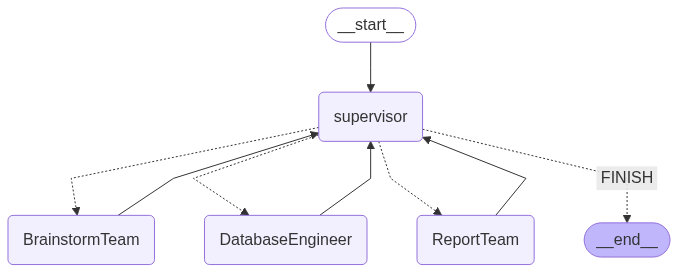

In [ ]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))


### Example Usage Scenarios

#### Scenario 1: Generate Patient Report

**Workflow**: Database lookup → Report generation → PDF creation

In [ ]:
try:
    for s in super_graph.stream(
        {
            "messages": [
                HumanMessage(content="Generate report of Sarah Taylor last visit")
            ],
        },
        {"recursion_limit": 250},
    ):
        if "__end__" not in s:
            print(s)
            print("---")
except Exception as e:
    print(e)

{'supervisor': {'next': 'DatabaseEngineer'}}
---
{'DatabaseEngineer': {'messages': [HumanMessage(content="Here is the report of Sarah Taylor's last visits:\n\n1. **Date:** September 15, 2022\n   - **Diagnosis:** High cholesterol\n   - **Allergies:** Nuts\n   - **Medications:** Atorvastatin\n   - **Treatment History:** Dietary changes\n   - **Test Results:** Cardio stress test\n   - **Session:** 2\n   - **Meeting Summary:** Follow-up on lipid panel results, ordered cardio stress test to monitor heart health.\n\n2. **Date:** September 1, 2022\n   - **Diagnosis:** High cholesterol\n   - **Allergies:** Nuts\n   - **Medications:** Atorvastatin\n   - **Treatment History:** Dietary changes\n   - **Test Results:** Lipid panel\n   - **Session:** 1\n   - **Meeting Summary:** Discussed patient's symptoms and medical history, diagnosed with high cholesterol and prescribed Atorvastatin.\n\nIf you need more details or further assistance, feel free to ask!", additional_kwargs={}, response_metadata={}

#### Scenario 2: Clinical Investigation

**Workflow**: Database lookup → Medical research → Clinical analysis → Recommendations

In [ ]:
try:
    for s in super_graph.stream(
        {
            "messages": [
                HumanMessage(
                    content="What might be the reason of high sugar levels of Sarah Taylor?"
                )
            ],
        },
        {"recursion_limit": 250},
    ):
        if "__end__" not in s:
            print(s)
            print("---")
except Exception as e:
    print(e)

{'supervisor': {'next': 'DatabaseEngineer'}}
---
{'DatabaseEngineer': {'messages': [HumanMessage(content='The high sugar levels of Sarah Taylor might be influenced by her medical history of high cholesterol and family medical history of obesity. Additionally, she has an allergy to nuts, which could also play a role in her overall health and dietary choices.', additional_kwargs={}, response_metadata={}, name='DatabaseEngineer')]}}
---
{'supervisor': {'next': 'ReportTeam'}}
---
{'ReportTeam': {'messages': [HumanMessage(content='It seems there is an issue with generating the report due to missing required information. To create a structured medical report for Sarah Taylor, I need to include specific details such as her name, age, gender, and any other relevant medical history or observations.\n\nCould you please provide the following details for Sarah Taylor?\n\n1. Full Name\n2. Age\n3. Gender\n4. Any additional medical history or observations you would like to include in the report.', ad

#### Scenario 3: Patient History Summary

**Workflow**: Database queries → Data aggregation → Summary generation

In [ ]:
try:
    for s in super_graph.stream(
        {
            "messages": [
                HumanMessage(content="Summarize the visits of Mr. Bob Johnson")
            ],
        },
        {"recursion_limit": 250},
    ):
        if "__end__" not in s:
            print(s)
            print("---")
except Exception as e:
    print(e)

{'supervisor': {'next': 'DatabaseEngineer'}}
---
{'DatabaseEngineer': {'messages': [HumanMessage(content="Mr. Bob Johnson has had the following visits:\n\n1. **Date:** March 15, 2022\n   - **Diagnosis:** Diabetes\n   - **Allergies:** Soy\n   - **Medications:** Metformin\n   - **Treatment History:** Insulin therapy\n   - **Test Results:** Glucometer readings\n   - **Meeting Summary:** Discussed patient's symptoms and medical history, diagnosed with diabetes and prescribed Metformin and insulin therapy.\n\n2. **Date:** April 1, 2022\n   - **Diagnosis:** Diabetes\n   - **Allergies:** Soy\n   - **Medications:** Metformin\n   - **Treatment History:** Insulin therapy\n   - **Test Results:** Kidney function test\n   - **Meeting Summary:** Follow-up on glucometer readings, discussed kidney function test results and adjusted insulin dosage.\n\n3. **Date:** April 15, 2022\n   - **Diagnosis:** Diabetes\n   - **Allergies:** Soy\n   - **Medications:** Metformin\n   - **Treatment History:** Insulin 